<a href="https://colab.research.google.com/github/clarabarretto/garbage-classification/blob/main/garbage_classification_annotated_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Projeto de Classificação de Lixo com Transfer Learning

Este notebook demonstra a construção de um classificador de lixo utilizando **transfer learning** com o MobileNetV2.  O objetivo é treinar um modelo robusto capaz de classificar imagens de diferentes tipos de resíduos.  Para evitar overfitting e garantir generalização, aplicamos técnicas modernas como **separação em conjuntos de treino/validação/teste**, **data augmentation**, **regularização**, **early stopping** e **fine‑tuning**.  Também realizamos uma **análise exploratória** prévia do conjunto de dados.


In [ ]:
# Instalação das bibliotecas necessárias
# Observação: a instalação de pacotes via pip pode não ser necessária se as bibliotecas já estiverem presentes no ambiente.
!pip install kagglehub tensorflow matplotlib seaborn pandas scikit-learn


In [ ]:
# Importação das bibliotecas úteis
import kagglehub  # para baixar o dataset do Kaggle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

print("Versão do TensorFlow:", tf.__version__)


Versão do TensorFlow: 2.19.0



## 1. Download e caminho do dataset

Utilizamos a biblioteca `kagglehub` para baixar automaticamente o conjunto de dados **Garbage Classification**.  Após o download, definimos o caminho correto para a pasta que contém as imagens.


In [ ]:
# --- 2. DOWNLOAD E CAMINHO DO DATASET ---
print("Baixando o dataset...")
DATASET_PATH = kagglehub.dataset_download("asdasdasasdas/garbage-classification")
# O dataset baixado contém subpastas; ajustamos o caminho para chegar às imagens
CORRECT_DATA_PATH = os.path.join(DATASET_PATH, 'Garbage classification', 'Garbage classification')
print(f"Caminho para os dados: {CORRECT_DATA_PATH}")


Baixando o dataset...
Caminho para os dados: /kaggle/input/garbage-classification/Garbage classification/Garbage classification



## 2. Análise Exploratória de Dados (EDA)

Nesta seção, identificamos as classes presentes no conjunto de dados e verificamos a quantidade de imagens em cada classe.  Também visualizamos algumas amostras de cada classe para entender melhor a variabilidade das imagens.


Classes encontradas: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Número de imagens por classe:        classe  quantidade
0  cardboard         403
1      glass         501
2      metal         410
3      paper         594
4    plastic         482
5      trash         137


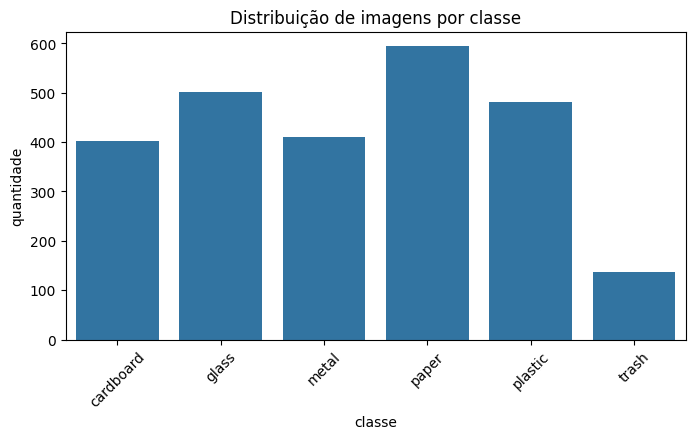

In [ ]:
# --- 3. ANÁLISE EXPLORATÓRIA DE DADOS (EDA) ---
# Listar as classes e contar quantas imagens há em cada uma
try:
    class_names = sorted(os.listdir(CORRECT_DATA_PATH))
    print(f"Classes encontradas: {class_names}")
except FileNotFoundError:
    raise FileNotFoundError(f"ERRO: O diretório '{CORRECT_DATA_PATH}' não foi encontrado.")

# Contar número de imagens por classe
counts = []
for class_name in class_names:
    class_dir = os.path.join(CORRECT_DATA_PATH, class_name)
    num_images = len(os.listdir(class_dir))
    counts.append({"classe": class_name, "quantidade": num_images})

# Criar DataFrame para exibir os resultados
counts_df = pd.DataFrame(counts)
print("Número de imagens por classe: ", counts_df)

# Plotar distribuição das classes
plt.figure(figsize=(8,4))
sns.barplot(x='classe', y='quantidade', data=counts_df)
plt.xticks(rotation=45)
plt.title('Distribuição de imagens por classe')
plt.show()


Exibindo amostras de cada classe:


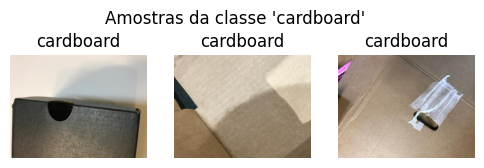

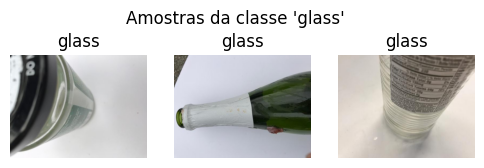

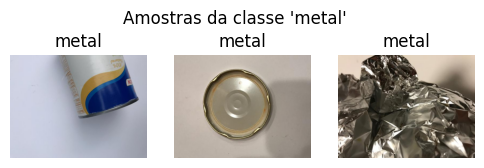

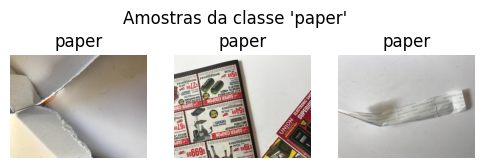

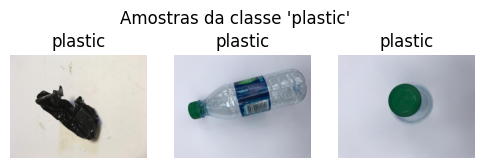

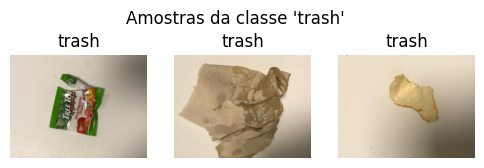

In [ ]:
# Exibir algumas amostras de cada classe
print("Exibindo amostras de cada classe:")
num_samples = 3  # número de amostras por classe
aut = 0
for class_name in class_names:
    class_dir = os.path.join(CORRECT_DATA_PATH, class_name)
    sample_files = os.listdir(class_dir)[:num_samples]
    plt.figure(figsize=(num_samples * 2, 2))
    for i, fname in enumerate(sample_files):
        img_path = os.path.join(class_dir, fname)
        img = plt.imread(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(class_name)
    plt.suptitle(f"Amostras da classe '{class_name}'")
    plt.show()



## 3. Preparação dos dados

Para treinar e avaliar o modelo de forma imparcial, dividimos os dados em **treino**, **validação** e **teste** nas proporções 70 %, 15 % e 15 % respectivamente.  A divisão é feita de forma **estratificada** para que a proporção de cada classe seja preservada em todos os conjuntos.  Isso evita que o modelo tenha viés por conta de classes desbalanceadas e segue boas práticas de desenvolvimento de modelos【462466841058268†L96-L116】.

Cada imagem será redimensionada para 224 × 224 pixels.  Criamos funções auxiliares para carregar e pré‑processar as imagens e para montar `tf.data.Dataset` batched.


In [ ]:
# --- 4. PREPARAÇÃO DOS DADOS: DIVIDINDO EM TREINO, VALIDAÇÃO E TESTE ---
IMG_SIZE = 224
BATCH_SIZE = 32
RANDOM_SEED = 123

# Listar arquivos e labels
file_paths = []
labels = []
for idx, class_name in enumerate(class_names):
    class_dir = os.path.join(CORRECT_DATA_PATH, class_name)
    for fname in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, fname))
        labels.append(idx)

file_paths = np.array(file_paths)
labels = np.array(labels)

# Divisão estratificada em 70% treino, 15% validação e 15% teste
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.15, stratify=labels, random_state=RANDOM_SEED)

# A razão de validação em relação ao subset (treino + validação) é 15/85
val_ratio = 0.15 / 0.85
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=val_ratio,
    stratify=train_val_labels, random_state=RANDOM_SEED)

print(f"Total de amostras: {len(file_paths)}")
print(f"Conjunto de treino: {len(train_paths)} amostras")
print(f"Conjunto de validação: {len(val_paths)} amostras")
print(f"Conjunto de teste: {len(test_paths)} amostras")

# Função para carregar e pré-processar imagens
def load_and_preprocess(path, label):
    # Leitura do arquivo de imagem
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    # Redimensionamento
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img, label

AUTOTUNE = tf.data.AUTOTUNE

def create_dataset(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(buffer_size=len(paths), seed=RANDOM_SEED)
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_dataset = create_dataset(train_paths, train_labels, training=True)
val_dataset   = create_dataset(val_paths, val_labels)
test_dataset  = create_dataset(test_paths, test_labels)

print(f"Número de batches - treino: {train_dataset.cardinality()}, validação: {val_dataset.cardinality()}, teste: {test_dataset.cardinality()}")


Total de amostras: 2527
Conjunto de treino: 1768 amostras
Conjunto de validação: 379 amostras
Conjunto de teste: 380 amostras
Número de batches - treino: 56, validação: 12, teste: 12



## 4. Data augmentation e construção do modelo

Para melhorar a capacidade de generalização do modelo, aplicamos **data augmentation** (flips horizontais, rotações, zooms, translações e variação de contraste).  Isso cria versões ligeiramente diferentes das imagens originais, aumentando artificialmente o conjunto de treino e reduzindo o overfitting【486458246921683†L185-L196】.

Utilizamos **transfer learning** com a base pré‑treinada **MobileNetV2** (`weights='imagenet'`), congelando suas camadas no treinamento inicial.  Em seguida adicionamos:

- **Camada de redimensionamento e normalização**.
- **Camada GlobalAveragePooling2D** para reduzir a dimensão das features.
- **Camada Dropout** (taxa 0,5) para regularização extra, conforme técnica descrita por Srivastava et al. para reduzir a co‑adaptação de neurônios【874257158164438†L42-L53】.
- **Camada densa** com ativação softmax para classificação das classes.

O otimizador escolhido é o Adam e a função de perda é `sparse_categorical_crossentropy`, adequada para problemas de classificação multiclasse com rótulos inteiros.


In [ ]:
# --- 5. DATA AUGMENTATION E CONSTRUÇÃO DO MODELO (TRANSFER LEARNING) ---
# Camada de normalização: converte pixels para o intervalo [0,1]
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
], name='resize_and_rescale')

# Data augmentation: aumenta a diversidade das imagens de treino
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal', name='random_flip'),
    tf.keras.layers.RandomRotation(0.1, name='random_rotation'),
    tf.keras.layers.RandomZoom(0.1, name='random_zoom'),
    tf.keras.layers.RandomTranslation(0.1, 0.1, name='random_translation'),
    tf.keras.layers.RandomContrast(0.1, name='random_contrast')
], name='data_augmentation')

# Carregar a MobileNetV2 pré-treinada
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
# Congelar as camadas da base durante o treinamento inicial
base_model.trainable = False

# Construção do modelo completo
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_image')
x = data_augmentation(inputs)
# x = resize_and_rescale(x)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
# Redução de dimensionalidade
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(x)

# Camada relu
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001), name='feature_refiner')(x)

# Regularização com Dropout
x = tf.keras.layers.Dropout(0.5, name='dropout')(x)
# Camada de saída
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax',
                                kernel_regularizer=l2(0.001), name='classifier')(x)

model = tf.keras.Model(inputs, outputs, name='waste_classifier_mobilenetv2')

# Compilação do modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Resumo do modelo
model.summary()


Model: "waste_classifier_mobilenetv2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool                 │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_refiner (Dense)         │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,462 (9.87 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


## 5. Cálculo de pesos das classes

Quando os dados são desbalanceados (algumas classes têm muito mais exemplos que outras), o modelo tende a favorecer as classes majoritárias.  Para corrigir isso, calculamos **pesos de classe** com `compute_class_weight` e passamos esses pesos para o método `fit`.  Assim, cada classe contribui proporcionalmente para a perda.


In [ ]:
# --- 6. CÁLCULO DOS PESOS DAS CLASSES ---
# Calcular pesos para equilibrar classes durante o treinamento
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = dict(enumerate(class_weights))
print("Pesos calculados para as classes:", class_weight_dict)


Pesos calculados para as classes: {0: np.float64(1.044917257683215), 1: np.float64(0.8395061728395061), 2: np.float64(1.0303030303030303), 3: np.float64(0.7083333333333334), 4: np.float64(0.8717948717948718), 5: np.float64(3.101754385964912)}



## 6. Treinamento inicial com callbacks

No treinamento inicial, mantemos as camadas da base congeladas e treinamos apenas o topo da rede.  Utilizamos os seguintes **callbacks**:

- **EarlyStopping**: monitora a perda de validação e interrompe o treinamento se ela não melhorar após algumas épocas, prevenindo overfitting【252483670734704†L80-L107】.
- **ReduceLROnPlateau**: reduz a taxa de aprendizado quando a perda de validação se estabiliza, ajudando o modelo a convergir para mínimos mais estáveis.

Treinamos por 10 épocas iniciais, podendo parar antes conforme o EarlyStopping.


In [ ]:
# --- 7. TREINAMENTO INICIAL COM CALLBACKS ---
initial_epochs = 1000000000

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
]

print("Iniciando o treinamento inicial...")
history_initial = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=val_dataset,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


Iniciando o treinamento inicial...
Epoch 1/1000000000
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 198ms/step - accuracy: 0.4033 - loss: 2.8411 - val_accuracy: 0.7098 - val_loss: 1.1412 - learning_rate: 0.0050
Epoch 2/1000000000
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.6692 - loss: 1.3304 - val_accuracy: 0.7863 - val_loss: 0.9988 - learning_rate: 0.0050
Epoch 3/1000000000
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.7164 - loss: 1.1268 - val_accuracy: 0.8021 - val_loss: 0.9050 - learning_rate: 0.0050
Epoch 4/1000000000
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.7389 - loss: 1.0119 - val_accuracy: 0.7995 - val_loss: 0.8583 - learning_rate: 0.0050
Epoch 5/1000000000
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.7101 - loss: 1.0245 - val_accuracy: 0.7625 - val_loss: 0.9441 - learning_rate: 0.0050
Epoch 6/1000000000
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.7463 - loss: 0.9680 - val_accuracy: 0.7916 - val_loss: 0.8507 - learning_rate: 0.0050
Epoch 7/1


## 7. Ajuste fino (fine‑tuning)

Após o treinamento inicial, descongelamos parcialmente a base do MobileNetV2 para permitir que as camadas superiores se ajustem melhor ao nosso problema específico.  Somente as últimas 50 camadas (excluindo camadas de batch normalization) são treinadas, enquanto as demais permanecem congeladas.  A taxa de aprendizado é reduzida para evitar grandes atualizações nos pesos pré‑treinados.


In [ ]:
# # --- 8. AJUSTE FINO (FINE-TUNING) ---
# fine_tune_epochs = 1000000000
# total_epochs = initial_epochs + fine_tune_epochs

# # Descongelar parcialmente a base
# base_model.trainable = True
# for layer in base_model.layers[:-50]:
#     # Mantém camadas de batch normalization congeladas para estabilidade
#     if not isinstance(layer, tf.keras.layers.BatchNormalization):
#         layer.trainable = False

# # Recompilar modelo com taxa de aprendizado menor
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# callbacks_ft = [
#     EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
# ]

# print("Iniciando o ajuste fino...")
# history_fine_tune = model.fit(
#     train_dataset,
#     epochs=total_epochs,
#     initial_epoch=history_initial.epoch[-1] + 1,
#     validation_data=val_dataset,
#     class_weight=class_weight_dict,
#     callbacks=callbacks_ft
# )



## 8. Avaliação final

Após o fine‑tuning, avaliamos o modelo no conjunto de **teste** que permaneceu intocado durante o treinamento.  Calculamos a perda e a acurácia no teste, geramos um **relatório de classificação** detalhado e plotamos a **matriz de confusão** para visualizar os erros de classificação.


Avaliação final no conjunto de teste...
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8759 - loss: 0.5802
Loss no teste: 0.5750
Acurácia no teste: 0.8737
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
--- Relatório de Avaliação Detalhada ---
              precision    recall  f1-score   support

   cardboard       0.97      0.93      0.95        61
       glass       0.88      0.85      0.86        75
       metal       0.88      0.92      0.90        62
       paper       0.92      0.89      0.90        89
     plastic       0.82      0.82      0.82        72
       tras

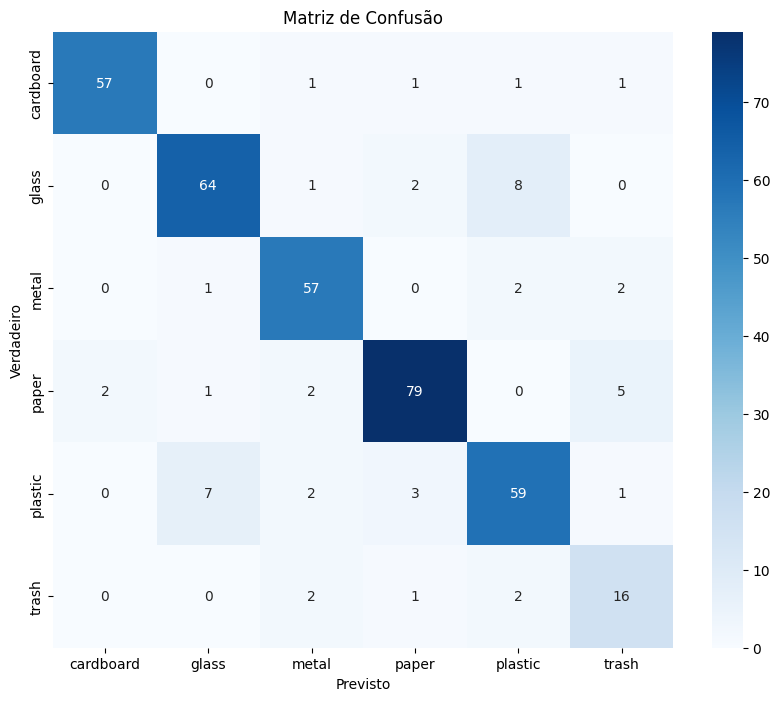

In [ ]:
# --- 9. AVALIAÇÃO FINAL NO CONJUNTO DE TESTE ---
print("Avaliação final no conjunto de teste...")
loss, accuracy = model.evaluate(test_dataset)
print(f"Loss no teste: {loss:.4f}")
print(f"Acurácia no teste: {accuracy:.4f}")

# Relatório de Classificação
y_pred = []
y_true = []
for images, labels in test_dataset:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

print("--- Relatório de Avaliação Detalhada ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de Confusão
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()



## 9. Histórico de treinamento

Para entender a evolução do modelo ao longo das épocas, combinamos os históricos do treinamento inicial e do fine‑tuning e visualizamos a acurácia e a perda para treino e validação.  A linha vertical pontilhada indica o início do ajuste fino.


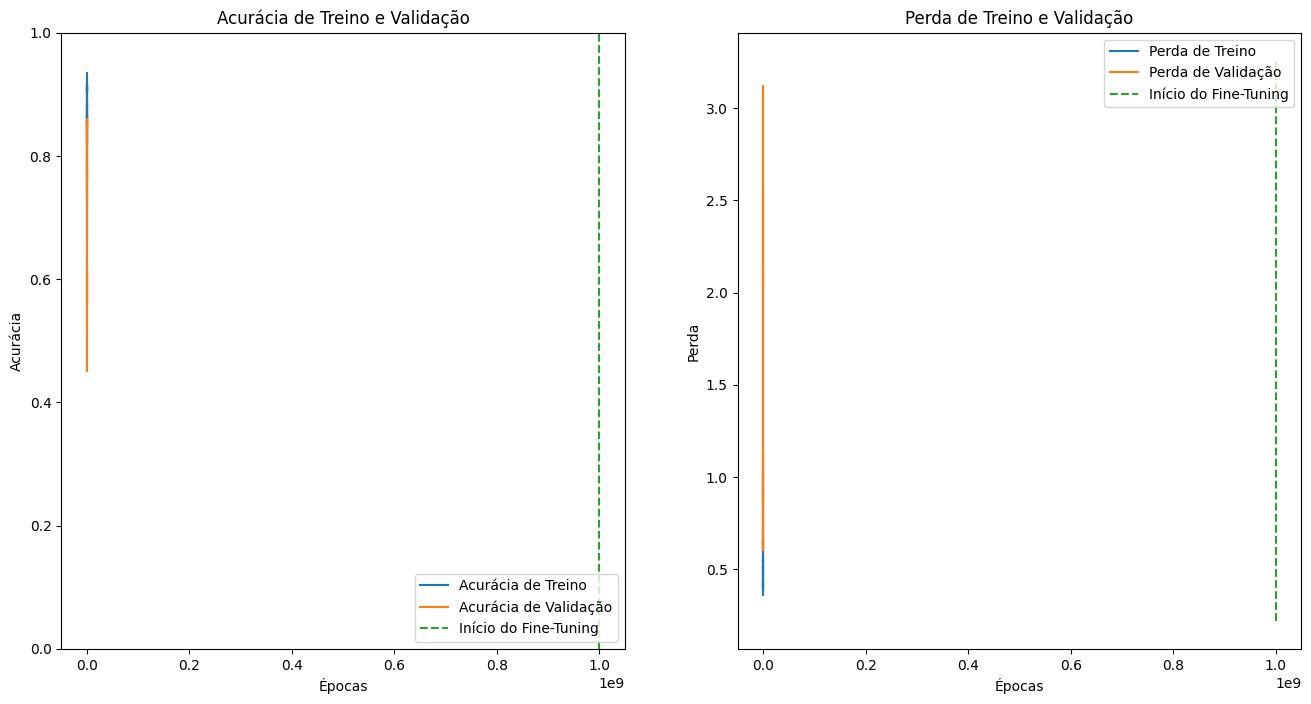

In [ ]:
# --- 10. PLOTAR HISTÓRICO DE TREINAMENTO ---
def plot_history(history_initial, history_fine_tune, initial_epochs):
    # Combina as métricas dos dois estágios
    acc = history_initial.history['accuracy'] + history_fine_tune.history['accuracy']
    val_acc = history_initial.history['val_accuracy'] + history_fine_tune.history['val_accuracy']
    loss = history_initial.history['loss'] + history_fine_tune.history['loss']
    val_loss = history_initial.history['val_loss'] + history_fine_tune.history['val_loss']

    plt.figure(figsize=(16, 8))
    # Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Acurácia de Treino')
    plt.plot(val_acc, label='Acurácia de Validação')
    plt.ylim([0, 1])
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Início do Fine-Tuning', linestyle='--')
    plt.legend(loc='lower right')
    plt.title('Acurácia de Treino e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')

    # Perda
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Perda de Treino')
    plt.plot(val_loss, label='Perda de Validação')
    plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Início do Fine-Tuning', linestyle='--')
    plt.legend(loc='upper right')
    plt.title('Perda de Treino e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.show()

plot_history(history_initial, history_fine_tune, initial_epochs)



## 10. Salvamento do modelo

Finalmente, salvamos o modelo treinado em formato Keras (`.keras`), permitindo que ele seja carregado posteriormente para inferência em um endpoint ou integrado a um frontend.


In [ ]:
# --- 11. SALVAMENTO DO MODELO ---
model_filename = 'waste_classifier_mobilenetv2.keras'
model.save(model_filename)
print(f" ✅ Modelo salvo com sucesso como '{model_filename}'")


 ✅ Modelo salvo com sucesso como 'waste_classifier_mobilenetv2.keras'
